## 8. Decision Tree class implemented in NumPy - with Bagging and AdaBoost

The following code contains a decision tree class that uses entropy to find the best split for each generated node.

A demonstration of the class and its functionality, including allowing impurity and limiting the number of nodes, is also given.

The class is also compatible with bagging and adaboost, both of which, and their benefits are demonstrated below.

In [1]:
import numpy as np
from spiral import spiral
import matplotlib.pyplot as plt
from scipy.stats import mode

In [2]:
class DecisionTree():
    """Decision tree class that is compatible with bagging and boosting"""
    
    def __init__(self, num_slices=10, impurity=0, max_nodes=1000, limit_dims=False, weights=False):
    
        self.tree = []
        self.node_count = 0
        self.branches = 0
        self.num_slices = num_slices #number of splits investigated in each dimension
        self.eps = impurity          #allow for impurity in leaf nodes
        self.max_nodes = max_nodes   #limit tree size
        self.limit_dims = limit_dims #limit splitting dimentions to a random choice for random forest
        self.weights = weights       #for boosting

    def get_entropy(self, x, weight=None):
        """Calculates the entropy of a group of samples, accepts sample labels, and weights if boosting"""
        
        entropy = 0
        
        if weight == None:
            cats = np.unique(x)
            for c in cats:
                p = len(x[x == c]) / len(x)
                entropy += - p * np.log2(p)
        
        else:
            cats = np.unique(x[:, 1])
            for c in cats:
                p = sum(x[:, 0][x[:, 1] == c]) / weight
                entropy += - p * np.log2(p)
            
        return entropy

    def get_split(self, x):
        """Finds the split that results in the lowest entropy for the given sample set"""

        if self.weights == True:
            dims = x.shape[1] - 2
        else:
            dims = x.shape[1] - 1
        
        best_dim_ents = np.zeros(dims)     #stores the best entropy values for each dimension
        best_slice_values = np.zeros(dims) #stores corresponding slice values
        for d in range(dims):
            
            #gets evenly spaced slices for given num_slices
            slices = np.linspace(min(x[:, d]), max(x[:, d]), self.num_slices + 2)[1:-1]

            dim_entropies = np.zeros(len(slices)) #stores entropies of each slice
            i = 0
            for s in slices:
                
                if self.weights == True:
                    l_slice = x[:, -2:][x[:, d] <= s]
                    r_slice = x[:, -2:][x[:, d] > s]
                    l_weight = sum(l_slice[:, 0])
                    r_weight = sum(r_slice[:, 0])
                    
                    dim_entropies[i] = (self.get_entropy(l_slice, l_weight)*l_weight + 
                                        self.get_entropy(r_slice, r_weight)*r_weight)/(l_weight + r_weight)
                    
                else:
                    l_slice = x[:, -1][x[:, d] <= s]
                    r_slice = x[:, -1][x[:, d] > s]

                    dim_entropies[i] = (self.get_entropy(l_slice)*len(l_slice) + 
                                        self.get_entropy(r_slice)*len(r_slice))/len(x)
                i += 1
            
            best_dim_ents[d] = min(dim_entropies)
            best_slice_values[d] = slices[np.argmin(dim_entropies)]
        
        #picks the best split from a random sample of the dimensions (for random forest)
        if self.limit_dims == True:
            k = int(np.round(np.sqrt(dims)))
            dim_choice = np.random.choice(dims, size=k, replace=False)
            dim_ents = best_dim_ents[dim_choice]
            slice_dim = dim_choice[np.argmin(dim_ents)]
            slice_value = best_slice_values[slice_dim]
        
        #gets best split for the given samples
        else:
            slice_dim = np.argmin(best_dim_ents)
            slice_value = best_slice_values[slice_dim]
        
        #splits samples
        left_branch = x[x[:, slice_dim] <= slice_value] #left = less than
        right_branch = x[x[:, slice_dim] > slice_value] #right = greater than

        return slice_dim, slice_value, left_branch, right_branch

    def build_tree(self, slice_dim, slice_value, left_branch, right_branch):
        """Takes the split data and the information about how the split was made then creates a new node
        to add to the tree, also checks if the branches of the new node are pure, if so a leaf node is created."""
        
        if self.tree == []: #for initial split
            split_dict = {'idx': 0, 'value': slice_value, 'dim': slice_dim, 'l_child': 1, 'r_child': 2, 
                            'l_data': left_branch, 'r_data': right_branch}
            self.branches += 2

        else:
            split_dict = {'idx': self.node_count + 1, 'value': slice_value, 'dim': slice_dim, 
                            'l_data': left_branch, 'r_data': right_branch}
            self.node_count +=1
            self.branches +=2
        
        #checks if left branch is pure, if so leaf node is created
        if self.get_entropy(left_branch[:, -1]) <= self.eps:
            leaf_dict = {'idx': self.node_count + 1, 'value': mode(left_branch[:, -1])}
            self.tree.append(leaf_dict)
            del split_dict['l_data']      #data removed as leaf node has been created with class value
            split_dict['l_child'] = self.node_count + 1  #leaf node becomes the left child of the split node
            self.node_count += 1

        if self.get_entropy(right_branch[:, -1]) <= self.eps:
            leaf_dict = {'idx': self.node_count + 1, 'value': mode(right_branch[:, -1])}
            self.tree.append(leaf_dict)
            del split_dict['r_data']
            split_dict['r_child'] = self.node_count + 1
            self.node_count += 1

        self.tree.append(split_dict)
        
    def finish_tree(self):
        """If the max_nodes limit has been reached any remaining impure branches are turned into leaf nodes"""
        
        #if l/r _data is present then it has impure unfinished branches
        for node in self.tree:
            if 'l_data' in node:
                leaf_dict = {'idx': self.node_count + 1}
                
                if self.weights == True: #if boosting, assigns node value based on weight
                    weights = np.array([1., 0., -1., 0.]).reshape(2, 2)
                    weights[0, 1] = sum(node['l_data'][:, -2][node['l_data'][:, -1] == 1])
                    weights[1, 1] = sum(node['l_data'][:, -2][node['l_data'][:, -1] == -1])
                    leaf_dict['value'] = [weights[:, 0][np.argmax(weights[:, 1])]]
                else:
                    leaf_dict['value'] = mode(node['l_data'][:, -1])
                
                self.tree.append(leaf_dict)
                node['l_child'] = self.node_count + 1
                del node['l_data']
                self.node_count += 1
                
            if 'r_data' in node:
                leaf_dict = {'idx': self.node_count + 1}
                
                if self.weights == True:
                    weights = np.array([1., 0., -1., 0.]).reshape(2, 2)
                    weights[0, 1] = sum(node['r_data'][:, -2][node['r_data'][:, -1] == 1])
                    weights[1, 1] = sum(node['r_data'][:, -2][node['r_data'][:, -1] == -1])
                    leaf_dict['value'] = [weights[:, 0][np.argmax(weights[:, 1])]]
                else:
                    leaf_dict['value'] = mode(node['r_data'][:, -1])
                
                self.tree.append(leaf_dict)
                node['r_child'] = self.node_count + 1
                del node['r_data']
                self.node_count += 1
        
    def train(self, data):
        """Accepts array of data with corresponding labels in the last column"""
        
        while True:
            
            #keeps track of impure branches
            count = 0
            
            #creates initial split
            if self.tree == []:
                d, v, l, r = self.get_split(data)
                self.build_tree(d, v, l, r)
                count +=1
            
            #loops through nodes checking for impure unfinished branches and gets the best split for the branch
            for node in self.tree:
                
                #checks if max_nodes requirement has been reached, if so finishes the tree
                if self.branches >= self.max_nodes:
                    self.finish_tree()
                    break
                    
                if 'l_data' in node:
                    d, v, l, r = self.get_split(node['l_data'])
                    node['l_child'] = self.node_count + 1
                    self.build_tree(d, v, l, r)
                    del node['l_data']
                    count += 1
                    
                if self.branches >= self.max_nodes:
                    self.finish_tree()
                    break

                if 'r_data' in node:
                    d, v, l, r = self.get_split(node['r_data'])
                    node['r_child'] = self.node_count + 1
                    self.build_tree(d, v, l, r)
                    del node['r_data']
                    count += 1
                    
            if count == 0: #if no impure branches remaining the tree is complete
                break
            if self.branches >= self.max_nodes:
                break
        
        #sorts the nodes by index, for predict method below
        self.tree = sorted(self.tree, key=lambda k: k['idx']) 

    def predict(self, data):
        """Accepts num_samples by num_dimentions array of data"""
        
        predictions = np.zeros(len(data))
        j = 0
        for x in data:
            i = 0 #index of next node
            while True:
                
                #checks if dim key is present, if not it must be a leaf node
                if 'dim' in self.tree[i]:
                    d = self.tree[i]['dim']
                    
                    #checks which side of the split the sample falls on, then updates i to corresponding node index
                    if x[d] <= self.tree[i]['value']: 
                        i = self.tree[i]['l_child']
                    else:
                        i = self.tree[i]['r_child']
                        
                #if its a leaf node, returns class prediction
                else:
                    predictions[j] = self.tree[i]['value'][0]
                    j += 1
                    break
                    
        return predictions
        

In [3]:
def plot(data, xx, yy, z):

    fig, ax = plt.subplots(figsize=(8, 6))
    data0 = data[:, :2][data[:, -1] == 0]
    data1 = data[:, :2][data[:, -1] == 1]
    ax.contourf(xx, yy, z, [-1, 0.5, 1], colors=['b', 'r'], alpha=0.2)
    ax.scatter(data0[:, 0], data0[:, 1], color='b', label=0)
    ax.scatter(data1[:, 0], data1[:, 1], color='r', label=1)
    plt.legend()
    plt.show()

#### Generating some data for the tree to classify

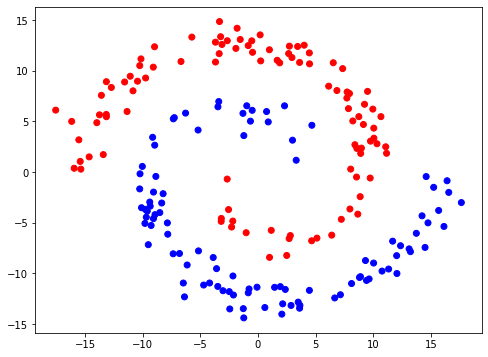

In [4]:
data = spiral(N=100, random_seed=10)
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(data[:, 0], data[:, 1], c=data[:, 2], cmap=plt.cm.bwr)
plt.show()

In [5]:
model = DecisionTree()
model.train(data)
print(sum(model.predict(data[:, :2]) == data[:, -1]), 'out of 200')

200 out of 200


In [6]:
model.node_count

20

#### The model achieves 100% accuracy on the training data but has some peculiarities that are common in decision trees, as its clear the blue boundary should not cut through the red spiral in the way it does below.
#### These peculiarites can result in high test error (high variance).

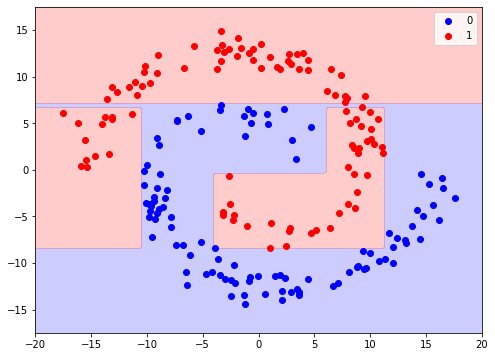

In [7]:
xx, yy = np.meshgrid(np.linspace(-20, 20, 100), np.linspace(-17.5, 17.5, 100))
mesh = np.vstack((np.ravel(xx), np.ravel(yy))).T
z = model.predict(mesh)
z = z.reshape(xx.shape)
plot(data, xx, yy, z)

#### Generating some more test data from the same distribution

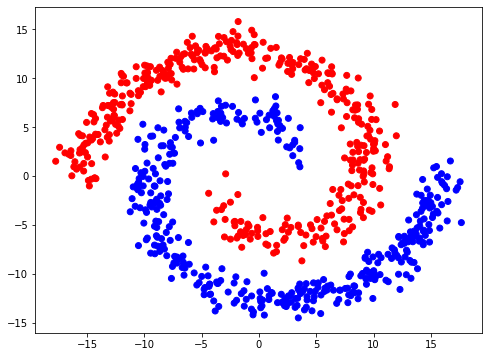

In [8]:
new_data = spiral(N=400, random_seed=6)
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(new_data[:, 0], new_data[:, 1], c=new_data[:, 2], cmap=plt.cm.bwr)
plt.show()

#### When the classifier is applied to the new test data it results in 26 missclassifications

In [9]:
print(sum(model.predict(new_data[:, :2]) == new_data[:, -1]), 'out of 800')

774 out of 800


#### Limiting the nodes results in higher training and test error

In [10]:
model2 = DecisionTree(max_nodes=16)
model2.train(data)
print(sum(model2.predict(data[:, :2]) == data[:, -1]), 'out of 200')

187 out of 200


In [11]:
model2.node_count

16

In [12]:
print(sum(model2.predict(new_data[:, :2]) == new_data[:, -1]), 'out of 800')

736 out of 800


#### Allowing some impurity in the leaf nodes results in higher training error and lower test error but the difference is only slight

In [13]:
model3 = DecisionTree(impurity=0.25)
model3.train(data)
print(sum(model3.predict(data[:, :2]) == data[:, -1]), 'out of 200')

198 out of 200


In [14]:
print(sum(model3.predict(new_data[:, :2]) == new_data[:, -1]), 'out of 800')

778 out of 800


# Bagging (random forest)

One of the most effective methods of improving a classifier with high variance is bagging.

When applied to decision trees it involes generating m decision trees that are grown all the way to their full depth so that every leaf node is pure.

In order to ensure the trees are all different, m datasets are generated by sampling with replacement m times from the original dataset. Additionally it is common to limit the number of dimentions considered for each split in the tree to a random set of k dimentions.

In [15]:
class RandomForest():
    """Random forest class that utilises the DecisionTree class"""
    
    def __init__(self, num_trees=100, num_slices=10, limit_dims=True):
        
        self.num_trees = num_trees
        self.num_slices = num_slices
        self.forest = []
        self.limit_dims = limit_dims #limit dimentions considered for each split to a random selection
    
    def gen_trees(self):
        """Generates the chosen number of trees and stores them in the forest"""
        
        for tree in range(self.num_trees):

            self.forest.append(DecisionTree(self.num_slices, limit_dims=self.limit_dims))
    
    def train_trees(self, data):
        """accepts array of data with the labels in the last column"""
        
        self.gen_trees()
        
        for tree in self.forest:
            
            x = data[np.random.choice(len(data), size=len(data), replace=True)]
            
            tree.train(x)

    def predict(self, data):
        """accepts num_samples by num_dimentions array of data"""
            
        predictions_sum = np.zeros(len(data))

        for tree in self.forest:

            predictions_sum += tree.predict(data)
            
        #returns the average prediction
        predictions = np.round(predictions_sum / len(self.forest))
        
        return predictions

#### applying bagging to this dataset (without limiting the dimentions) produces a model without the peculiarities seen when only one tree is used, resulting in low training error and low test error

In [16]:
forest_model = RandomForest(30, limit_dims=False)
forest_model.train_trees(data)
sum(forest_model.predict(data[:, :2]) == data[:, -1])

200

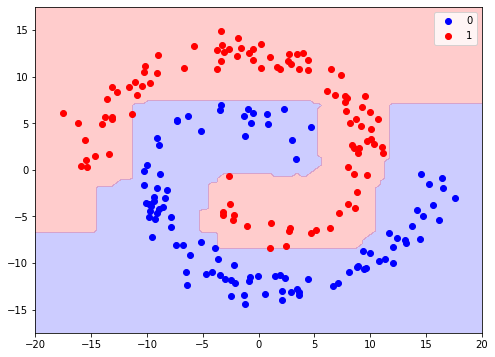

In [17]:
z1 = forest_model.predict(mesh)
z1 = z1.reshape(xx.shape)
plot(data, xx, yy, z1)

In [18]:
print(sum(forest_model.predict(new_data[:, :2]) == new_data[:, -1]), 'out of 800')

794 out of 800


#### Limiting the dimentions to a random choice for each split produces similar results but is less consistant for this dataset as it only has two dimentions to divide on

In [26]:
forest_model2 = RandomForest(30, limit_dims=True)
forest_model2.train_trees(data)
sum(forest_model2.predict(data[:, :2]) == data[:, -1])

200

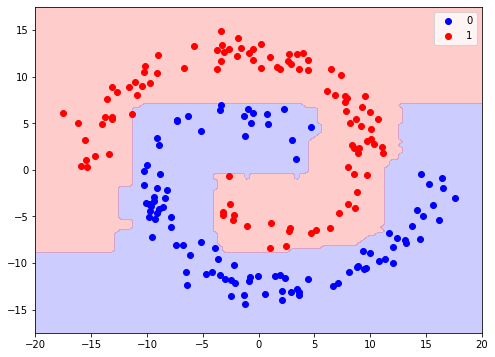

In [27]:
z2 = forest_model2.predict(mesh)
z2 = z2.reshape(xx.shape)
plot(data, xx, yy, z2)

In [28]:
print(sum(forest_model2.predict(new_data[:, :2]) == new_data[:, -1]), 'out of 800')

792 out of 800


# Boosting

Another method for imporiving decision trees and other classifiers with high bias is boosting.
This involves combining together many weak classifiers to form one strong classifier.

A popular method of boosting classifiers is AdaBoost. When applied to decision trees it involves producing many very shallow trees and combining their results together. To ensure each generated tree is different each training sample is given a new weighting after each iteration. Missclassified points are given a larger weighting and correctly classified points a lower weighting. This ensures the next tree puts more focus on classifying previously missclassified samples correctly. The classifiers themselves are also given a weighting (alphas) based on the number of samples they each classify correctly.

In [29]:
model4 = DecisionTree(num_slices=10, max_nodes=4)
model4.train(data)
print(sum(model4.predict(data[:, :2]) == data[:, -1]), 'out of 200')

147 out of 200


#### On its own a 4 node tree is a weak classifier on this dataset

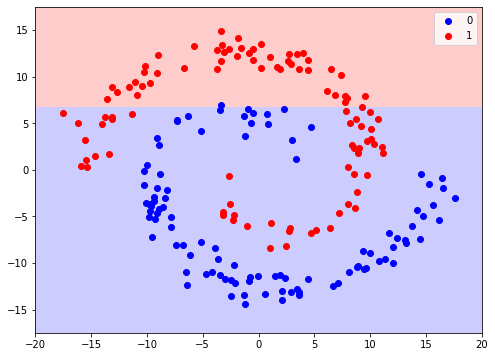

In [30]:
z4 = model4.predict(mesh)
z4 = z4.reshape(xx.shape)
plot(data, xx, yy, z4)

In [31]:
class AdaBoost():
    """AdaBoost class that utilises the DecisionTree class"""

    def __init__(self, iterations, max_nodes=4, num_slices=10):
        
        self.iterations = iterations
        self.max_nodes = max_nodes
        self.num_slices = num_slices
        self.alphas = []
        self.trees = []
        self.iters = 0

    def train(self, data):
        """Accepts array of samples with labels ∈{-1, 1} in the last column"""
        
        n = len(data)
        weights = np.ones(n)/n
        
        for t in range(self.iterations):

            x = np.hstack((data[:, :-1], weights[:, None], data[:, -1][:, None]))

            tree = DecisionTree(self.num_slices, max_nodes=self.max_nodes, weights=True)
            tree.train(x)
            predictions = tree.predict(x[:, :2])
            
            error = sum(weights[predictions != x[:, -1]])
            alpha = (1/2) * np.log((1 - error) / error)
            weights *= np.exp(-alpha * predictions * x[:, -1]) / (2 * np.sqrt(error*(1-error)))

            self.trees.append(tree)
            self.alphas.append(alpha)
            
            self.iters += 1

    def predict(self, data):
        """accepts num_samples by num_dimentions array of data"""
        
        tree_preds = np.array([tree.predict(data) for tree in self.trees])
        predictions = np.sign(tree_preds.T @ np.array(self.alphas)[:, None]).flatten()
                             
        return predictions

In [32]:
data2 = data.copy()
data2[:, -1] = np.where(data2[:, -1] == 0, -1, 1) #changing the 0 labels to -1 labels for adaboost

In [33]:
booster = AdaBoost(iterations=80, max_nodes=4)
booster.train(data2)

In [34]:
predictions = booster.predict(data2[:, :-1])
sum(predictions == data2[:, -1])

200

#### When applied to this dataset it avoides the major peculiarities seen with a normal decision tree but is not as effective as bagging, and is more susceptible to overfitting

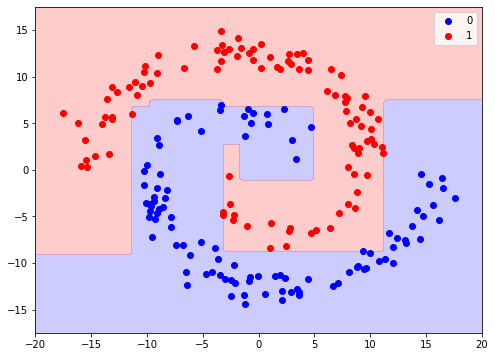

In [35]:
z3 = booster.predict(mesh)
z3 = z3.reshape(xx.shape)
plot(data, xx, yy, z3)

In [36]:
new_data2 = new_data.copy()
new_data2[:, -1] = np.where(new_data2[:, -1] == 0, -1, 1)
print(sum(booster.predict(new_data[:, :2]) == new_data2[:, -1]), 'out of 800')

779 out of 800
